## LSTM

**forget gate**

$$A^{(t)}_{0} = \sigma (X^{(t)}W_{0} + Y^{(t-1)}V_{0} + B_{0}) $$

**input gate**

$$A^{(t)}_{1} = \sigma (X^{(t)}W_{1} + Y^{(t-1)}V_{1} + B_{1}) $$

**new memory**

$$A^{(t)}_{2} = \tanh (X^{(t)}W_{2} + Y^{(t-1)}V_{2} + B_{2}) $$

**output gate**

$$A^{(t)}_{3} = \sigma (X^{(t)}W_{3} + Y^{(t-1)}V_{3} + B_{3}) $$

### Forward Propagation

$$U^{(t)}_{g} = X^{(t)}W_{g} + Y^{(t-1)}V_{g} + B_{g} $$  
$$A^{(t)}_{g} =  f_{g}(U^{(t)}_{g})$$  
$$C^{(t)} = A^{(t)}_{0} \circ C^{(t-1)} + A^{(t)}_{1} \circ A^{(t)}_{2} $$  
$$Y^{(t)} = A^{(t)}_{3} \circ \tanh(C^{(t)}) $$  

### sin Prediction

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
n_time = 10
n_in = 1
n_mid = 20
n_out = 1

eta = 0.01
epochs = 101
batch_size = 8
interval = 10

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [8]:
sin_x = np.linspace(-2 * np.pi, 2 * np.pi)
sin_y = np.sin(sin_x) + 0.1 * np.random.randn(len(sin_x))
n_sample = len(sin_x) - n_time
input_data = np.zeros((n_sample, n_time, n_in))
correct_data = np.zeros((n_sample, n_out))
for i in range(n_sample):
    input_data[i] = sin_y[i:i + n_time].reshape(-1, 1)
    correct_data[i] = sin_y[i + n_time]

**Layer**

In [17]:
class LSTMLayer:
    def __init__(self, n_upper, n):
        self.w = np.random.randn(4, n_upper, n) / np.sqrt(n) # Xavier init
        self.v = np.random.randn(4, n, n) / np.sqrt(n)
        self.b = np.zeros((4, n))
        
    def forward(self, x, y_prev, c_prev):
        u = np.matmul(x, self.w) + np.matmul(y_prev, self.v) + self.b.reshape(4, 1, -1)
        
        a0 = sigmoid(u[0])
        a1 = sigmoid(u[1])
        a2 = np.tanh(u[2])
        a3 = sigmoid(u[3])
        self.gates = np.stack((a0, a1, a2, a3))
        
        self.c = a0 * c_prev + a1 * a2
        self.y = a3 * np.tanh(self.c)
        
    def backward(self, x, y, c, y_prev, c_prev, gates, grad_y, grad_c):
        a0, a1, a2, a3 = gates
        tanh_c = np.tanh(c)
        r = grad_c + grad_y * a3 * (1 - tanh_c ** 2)
        
        delta0 = r * c_prev * a0 * (1 - a0)
        delta1 = r * a2 * a1 * (1 - a1)
        delta2 = r * a1 * (1 - a2 ** 2)
        delta3 = grad_y * tanh_c * a3 * (1 - a3)
        
        deltas = np.stack((delta0, delta1, delta2, delta3))
        
        self.grad_w += np.matmul(x.T, deltas)
        self.grad_v += np.matmul(y_prev.T, deltas)
        self.grad_b += np.sum(deltas, axis=1)
        
        grad_x = np.matmul(deltas, self.w.transpose(0, 2, 1))
        self.grad_x = np.sum(grad_x, axis=0)
        
        grad_y_prev = np.matmul(deltas, self.v.transpose(0, 2, 1))
        self.grad_y_prev = np.sum(grad_y_prev, axis=0)
        
        self.grad_c_prev = r * a0
        
    def reset_sum_grad(self):
        self.grad_w = np.zeros_like(self.w)
        self.grad_v = np.zeros_like(self.v)
        self.grad_b = np.zeros_like(self.b)
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.v -= eta * self.grad_v
        self.b -= eta * self.grad_b

class OutputLayer:
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = u
    
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

In [18]:
lstm_layer = LSTMLayer(n_in, n_mid)
output_layer = OutputLayer(n_mid, n_out)

In [27]:
def train(x_mb, t_mb):
    y_rnn = np.zeros((len(x_mb), n_time + 1, n_mid))
    c_rnn = np.zeros((len(x_mb), n_time + 1, n_mid))
    gates_rnn = np.zeros((4, len(x_mb), n_time, n_mid))
    y_prev = y_rnn[:, 0, :]
    c_prev = c_rnn[:, 0, :]
    for i in range(n_time):
        x = x_mb[:, i, :]
        
        lstm_layer.forward(x, y_prev, c_prev)
        
        y = lstm_layer.y
        y_rnn[:, i + 1, :] = y
        y_prev = y
        
        c = lstm_layer.c
        c_rnn[:, i + 1, :] = c
        c_prev = c
        
        gates = lstm_layer.gates
        gates_rnn[:, :, i, :] = gates
    
    output_layer.forward(y)
    output_layer.backward(t_mb)
    grad_y = output_layer.grad_x
    grad_c = np.zeros_like(lstm_layer.c)
    
    lstm_layer.reset_sum_grad()
    for i in reversed(range(n_time)):
        x = x_mb[:, i, :]
        y = y_rnn[:, i + 1, :]
        c = c_rnn[:, i + 1, :]
        y_prev = y_rnn[:, i, :]
        c_prev = c_rnn[:, i, :]
        gates = gates_rnn[:, :, i, :]
        
        lstm_layer.backward(x, y, c, y_prev, c_prev, gates, grad_y, grad_c)
        grad_y = lstm_layer.grad_y_prev
        grad_c = lstm_layer.grad_c_prev
    
    lstm_layer.update(eta)
    output_layer.update(eta)
    
def predict(x_mb):
    y_prev = np.zeros((len(x_mb), n_mid))
    c_prev = np.zeros((len(x_mb), n_mid))
    for i in range(n_time):
        x = x_mb[:, i, :]
        lstm_layer.forward(x, y_prev, c_prev)
        y = lstm_layer.y
        y_prev = y
        c = lstm_layer.c
        c_prev = c
    
    output_layer.forward(y)
    return output_layer.y

def get_error(x, t):
    y = predict(x)
    return 1.0 / 2.0 * np.sum(np.square(y - t)) # MSE

Epoch:1/101 Error:5.449724446994975


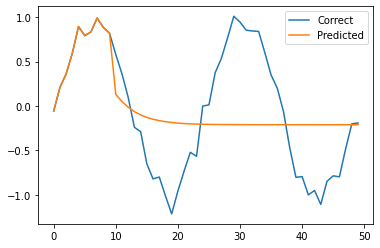

Epoch:11/101 Error:2.997230295060909


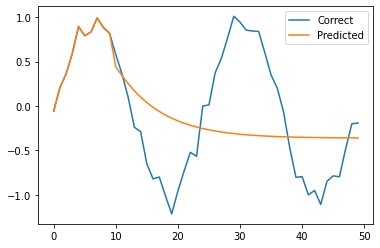

Epoch:21/101 Error:2.0076313534998826


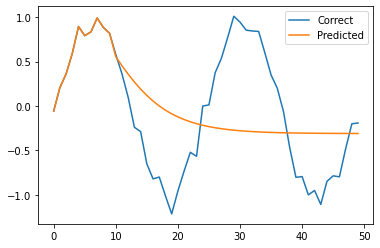

Epoch:31/101 Error:1.228661937958775


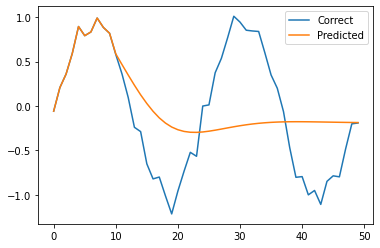

Epoch:41/101 Error:0.6499690815565241


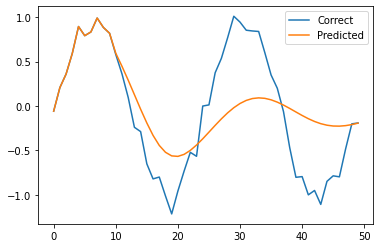

Epoch:51/101 Error:0.38260746294136283


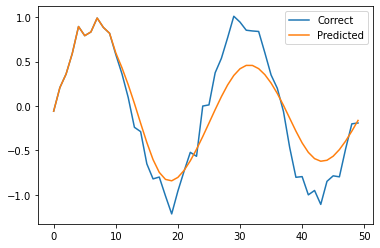

Epoch:61/101 Error:0.30595360982077235


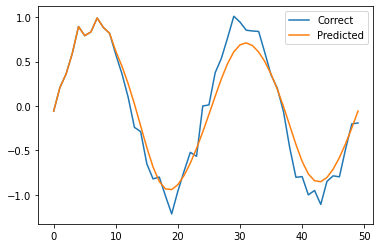

Epoch:71/101 Error:0.28933055772094907


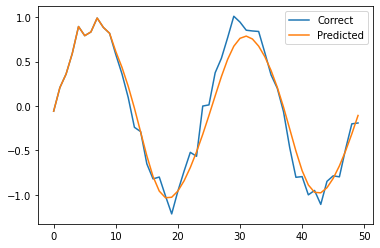

Epoch:81/101 Error:0.2830990771186555


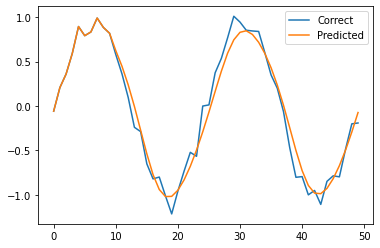

Epoch:91/101 Error:0.279834925692752


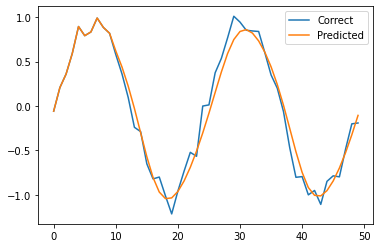

Epoch:101/101 Error:0.2771704664234323


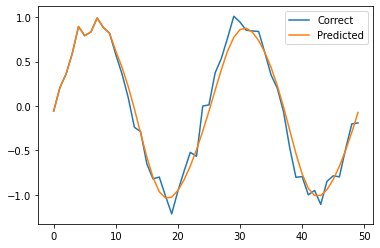

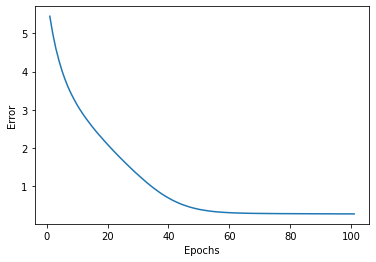

In [30]:
error_record = []
n_batch = len(input_data) // batch_size
for i in range(epochs):
    
    index_random = np.arange(len(input_data))
    np.random.shuffle(index_random)
    for j in range(n_batch):
        mb_index = index_random[j * batch_size:(j + 1) * batch_size]
        x_mb = input_data[mb_index, :]
        t_mb = correct_data[mb_index, :]
        train(x_mb, t_mb)
    
    error = get_error(input_data, correct_data)
    error_record.append(error)
    
    if i % interval == 0:
        print("Epoch:" + str(i + 1) + "/" + str(epochs), "Error:" + str(error))
        
        predicted = input_data[0].reshape(-1).tolist()
        for i in range(n_sample):
            x = np.array(predicted[-n_time:]).reshape(1, n_time, 1)
            y = predict(x)
            predicted.append(float(y[0, 0]))
            
        plt.plot(range(len(sin_y)), sin_y.tolist(), label="Correct")
        plt.plot(range(len(predicted)), predicted, label="Predicted")
        plt.legend()
        plt.show()
        
plt.plot(range(1, epochs + 1), error_record)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

### Text Generation